# process spectra for AuxTel with new spectractor (September 2021)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021
- last update : November 2nd 2021
- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

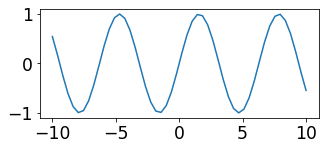

In [2]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [3]:
from iminuit import Minuit
import iminuit

In [4]:
iminuit.__version__

'2.7.0'

In [5]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [6]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [7]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

In [8]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [9]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [10]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [11]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [12]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [13]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [14]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [15]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [16]:
df=pd.read_csv(filename_logbook,index_col=0)

In [17]:
pd.set_option('display.max_rows', None)

In [18]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2000.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2000.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [19]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [20]:
#idx=76
#idx=96
#idx=76 # start of narrow scan

# Wide scan

#idx= 19  # outside
#idx=20 # outsie
#idx=21 # outside
#idx=22 # outside
#idx=23 # outside
#idx=24 # outside
#idx=25 # outside

#idx=26

#idx=50   # OK
#idx=51   # OK
#idx=52   # OK
#idx=53   # OK
#idx=54   # OK
#idx=55   # OK
idx=56   # OK

#idx=75

#--------

# narrow scan


#idx=111 # failed too close from border
#idx=112 # failed too close from border
#idx=113 # failed too close from border
#idx=114 # failed too close from border
#idx=115 # failed too close from border
#idx=116 # failed too close from border
#idx=117 # failed too close from border
#idx=118 # failed too close from border
#idx=119 # failed too close from border
#idx=120 # failed too close from border
#idx=121 # failed too close from border
#idx=122 # failed too close from border
#idx=123 # failed too close from border

In [21]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits


In [22]:
print(df.iloc[idx])

index                                                         56
date                                     2021-07-08T04:01:50.450
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000290_quick...
num                                                          290
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.025542
exposure                                                     2.0
focus                                                  -1.588317
seeing                                                       NaN
pressure                                                   742.5
temperature                                                 12.4
humidity                                                     5.0
windspd                  

In [23]:
myhome=os.getenv("HOME")

In [24]:
dir_images=path_images

In [25]:
dir_images

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07'

In [26]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits'

In [27]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [28]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [29]:
FLAG_ORDER0_LOCATION=False

In [30]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (300.0,2200.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [31]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000290_quickLookExp'

In [32]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [33]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [34]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp'

### manage output dir

In [35]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [36]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [37]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [38]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

2021-11-02 18:18:50  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.35090562277188 but average of self.read_out_noise is 8.5.


## Show relevant parameters

In [39]:
parameters.OBS_NAME

'AUXTEL'

In [40]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [41]:
parameters.DISTANCE2CCD

182.0

In [42]:
parameters.LAMBDA_MIN 

300

In [43]:
parameters.LAMBDA_MAX 

1100

In [44]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [45]:
image.filter_label

''

In [46]:
image.header["FILTER"]

'empty_1'

In [47]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

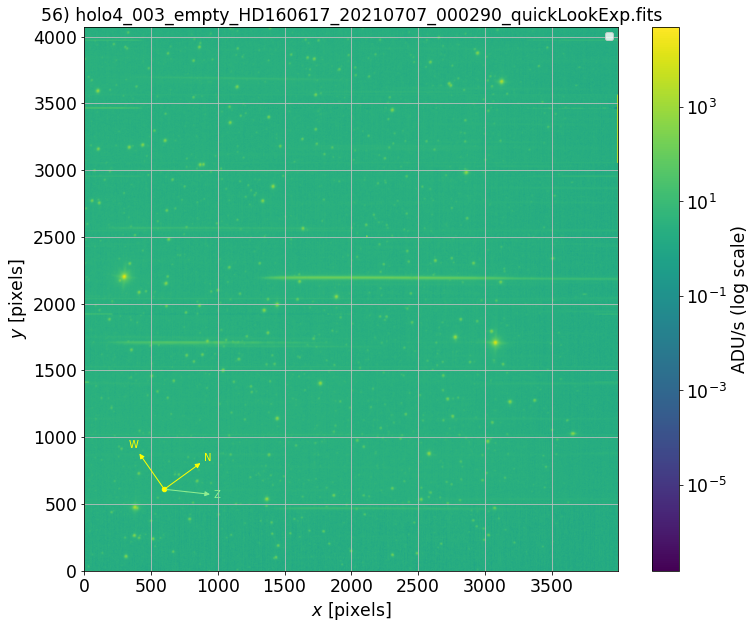

In [48]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [49]:
filename_image

'holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits'

In [50]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (300.0,2200.0)


## Let Spectractor find the location of the 0th order

2021-11-02 18:18:56  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                  c0_1        
    ----------------- --------------------- ---------------------
    4.784151460171134 0.0032102024025826657 0.0038300497163559167
2021-11-02 18:18:56  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 10 iterations because the relative change of cost is below ftol=1.25e-05.


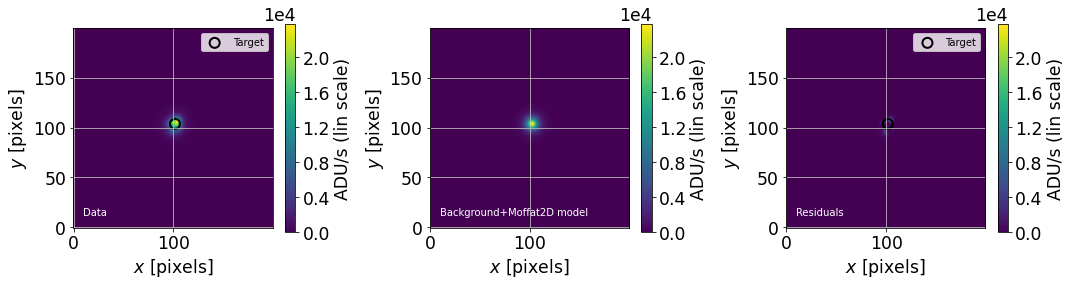

2021-11-02 18:18:57  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


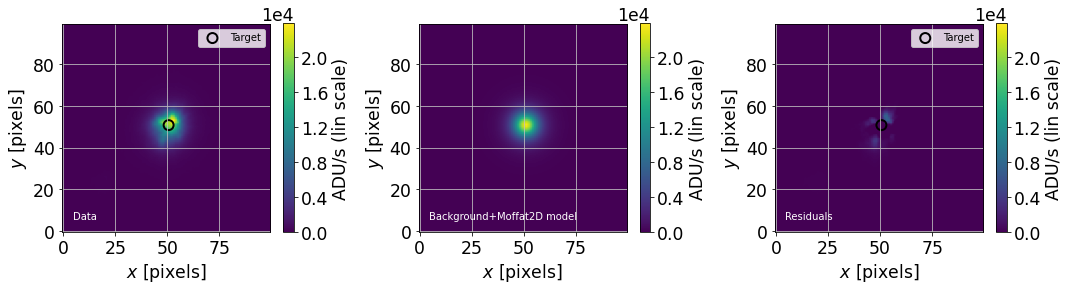

In [51]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [52]:
print(x1,y1)

301.6307125191803 2203.7598900192233


## Check the location of 0th order and Analysis of the quality of its focus

In [53]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [54]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [55]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [56]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [57]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [58]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [59]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [60]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [61]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [62]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [63]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [64]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [65]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-66-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '56) holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits')

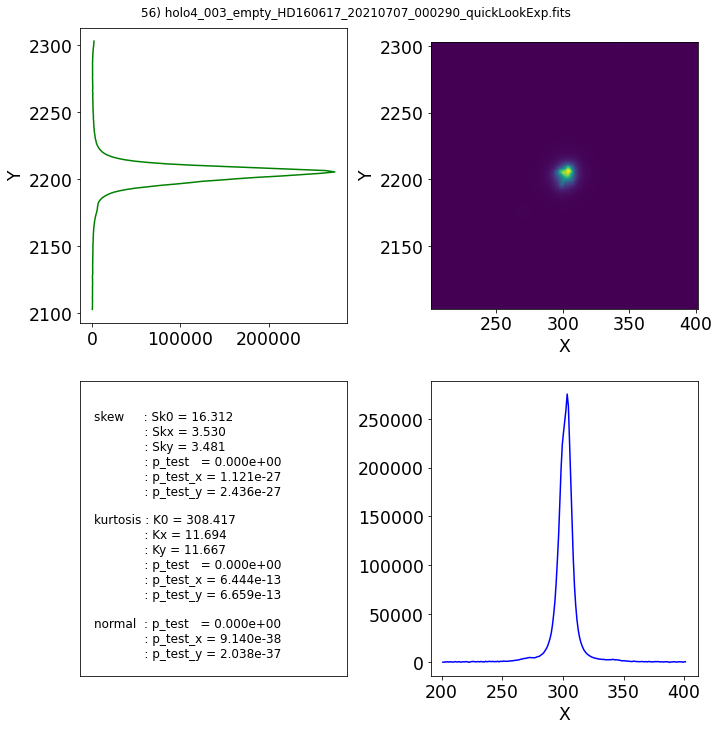

In [66]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [67]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [68]:
#parameters.debug=True
#parameters.verbose=True
#parameters.display=True
#parameters.LIVE_FIT=False

In [69]:
parameters.debug=False
parameters.verbose=False
parameters.display=True
parameters.LIVE_FIT=False

In [70]:
filename

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits'

2021-11-02 18:18:58  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-11-02 18:18:58  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp.fits...
2021-11-02 18:18:58  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-11-02 18:18:58  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-11-02 18:18:59  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-11-02 18:18:59  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-11-02 18:19:03  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.35090562277188 but average of self.read_out_noise is 8.5.
2021-11-02 18:19:03  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350              

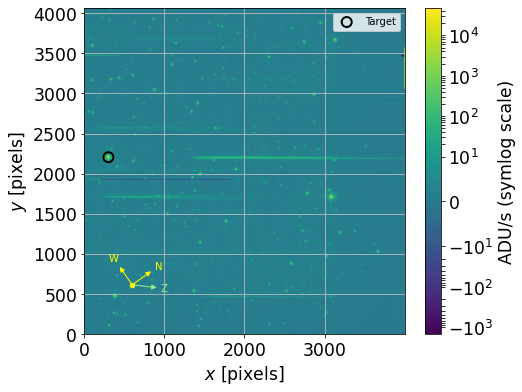

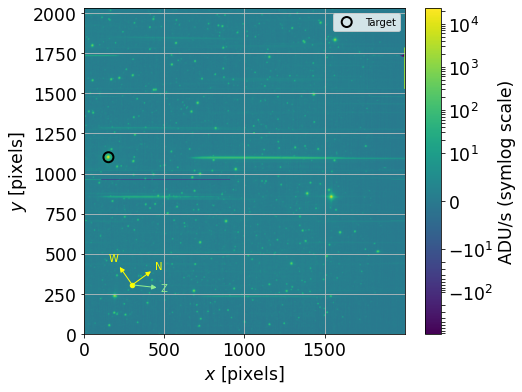

2021-11-02 18:19:09  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 150.81535626 1101.87994501]...
2021-11-02 18:19:10  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    4.3010415955469306 0.00372186328202865 0.002815530005517206
2021-11-02 18:19:10  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=5e-05.


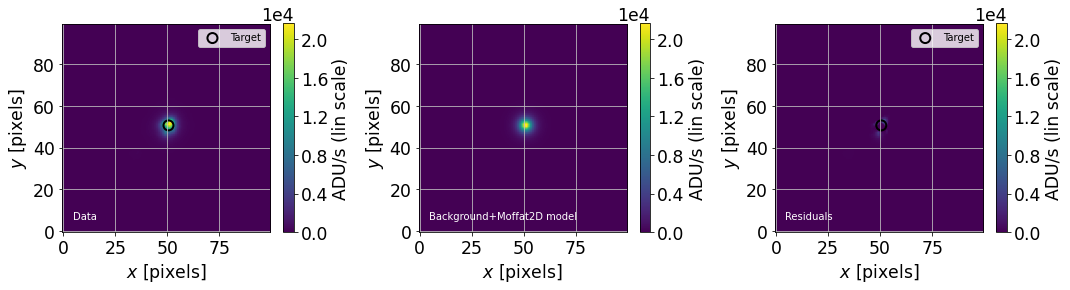

2021-11-02 18:19:11  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


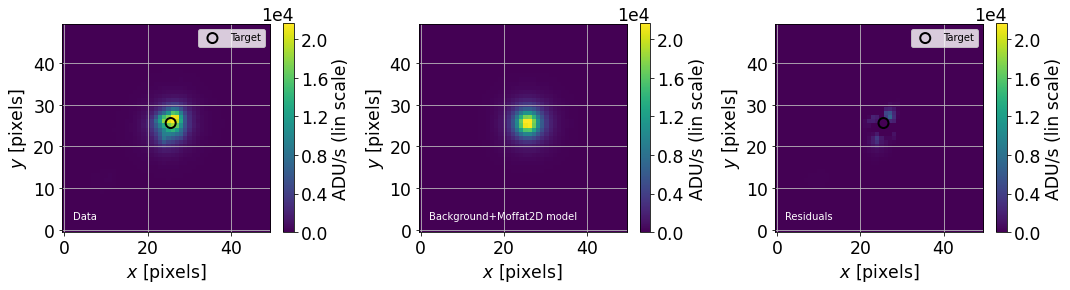

2021-11-02 18:19:11  Image      find_target          INFO   
	X,Y target position in pixels: 150.564,1101.630
2021-11-02 18:19:11  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


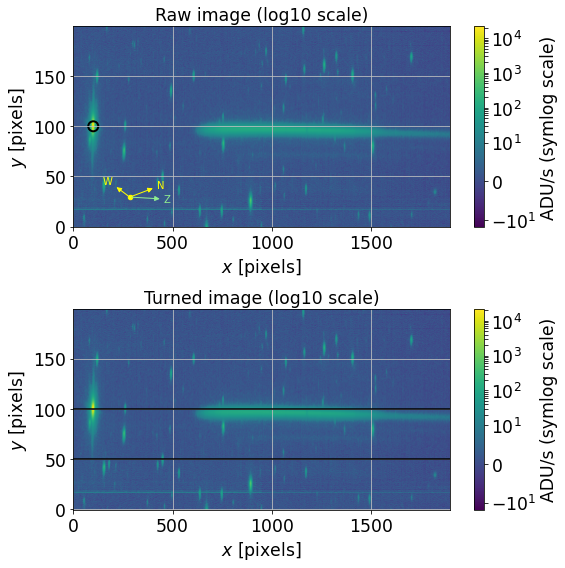

2021-11-02 18:19:16  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-11-02 18:19:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                  c0_1        
    ----------------- -------------------- ---------------------
    19.87236084989206 0.030958983156544457 -0.017853276103135283
2021-11-02 18:19:16  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


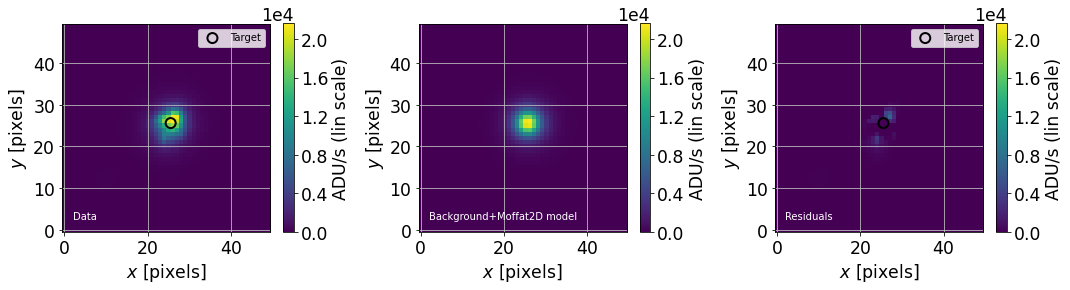

2021-11-02 18:19:17  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0008680555555555555.


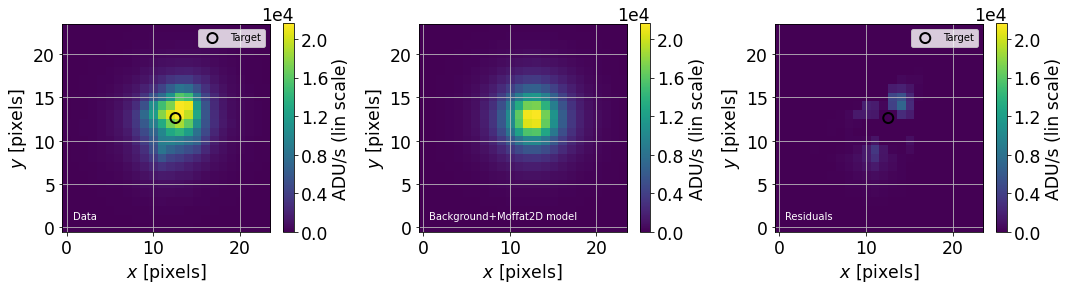

2021-11-02 18:19:18  Image      find_target          INFO   
	X,Y target position in pixels: 150.561,1101.620
2021-11-02 18:19:18  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-11-02 18:19:18  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-11-02 18:19:18  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [577:1735,1011:1191] (size (1158, 180))


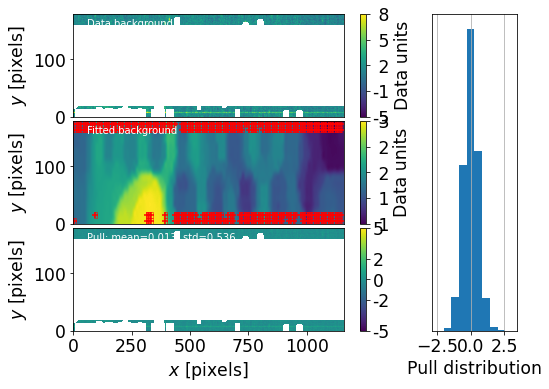

2021-11-02 18:19:20  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: divide by zero encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1256: RuntimeWarning: invalid value encountered in subtract
  a = x[imax + np.argmin(np.abs(y[imax:] - 0.9 * maximum))]
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1257: RuntimeWarning: invalid value encountered in subtract
  b = x[imax + np.argmin(np.abs(y[imax:] - 0.1 * maximum))]
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: invalid value encountered in true_divide
  out = evaluate_mof

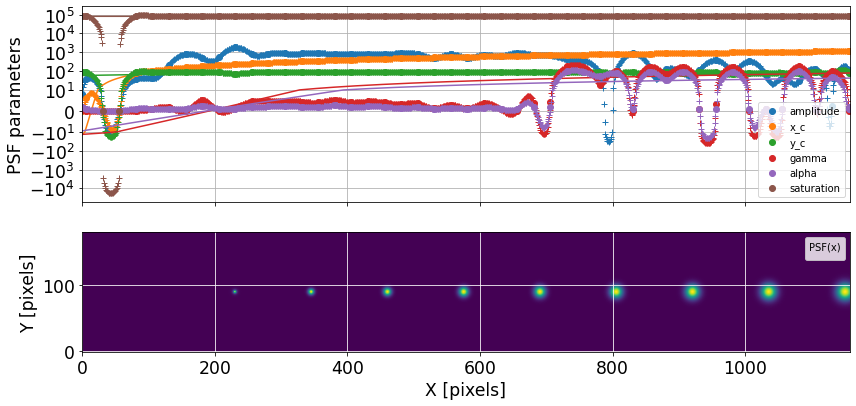

2021-11-02 18:19:24  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.3438e+05 initial chisq_red=5.0599
		 Line search: alpha_min=1.94 iter=0 funcalls=5
	Parameter shifts: [-0.09227115 -4.54061143  1.46486551 -2.77380984 -9.04462294 -6.36215777
  9.62659043 17.36850699 10.97250119]
	New parameters: [-7.0923965  -2.30967593 -5.61905838 18.97896144 25.70198199 15.15950848
 22.13695218 37.44493915 23.89807064]
	Final cost=1.0833e+05 final chisq_red=2.3387 computed in 0.60s
2021-11-02 18:19:24  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.0833e+05 initial chisq_red=2.3387
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [  1.74222929   0.19340012   3.14476227  -4.01425024  -6.19991583
   0.25631718 -13.58019037 -24.54226935 -15.2433754 ]
	New parameters: [-5.35016721 -2.11627581 -2.47429611 14.9647112  19.50206616 15.41582566
  8.55676181 12.9026698   8.65469524]
	Final cost=51896 final chisq_red=1.1204 com

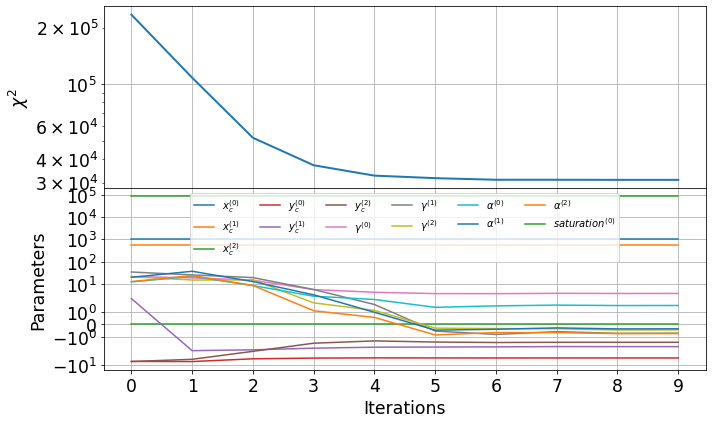

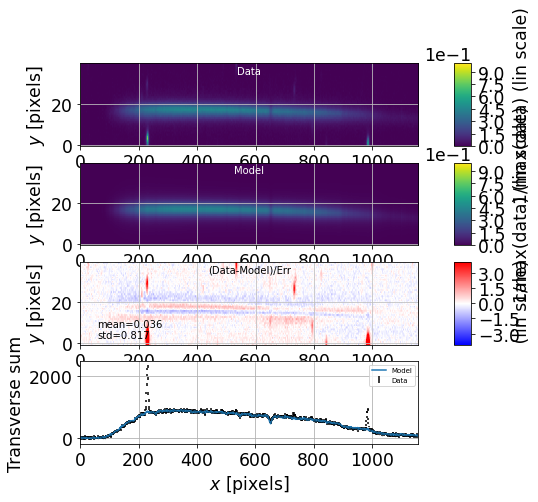

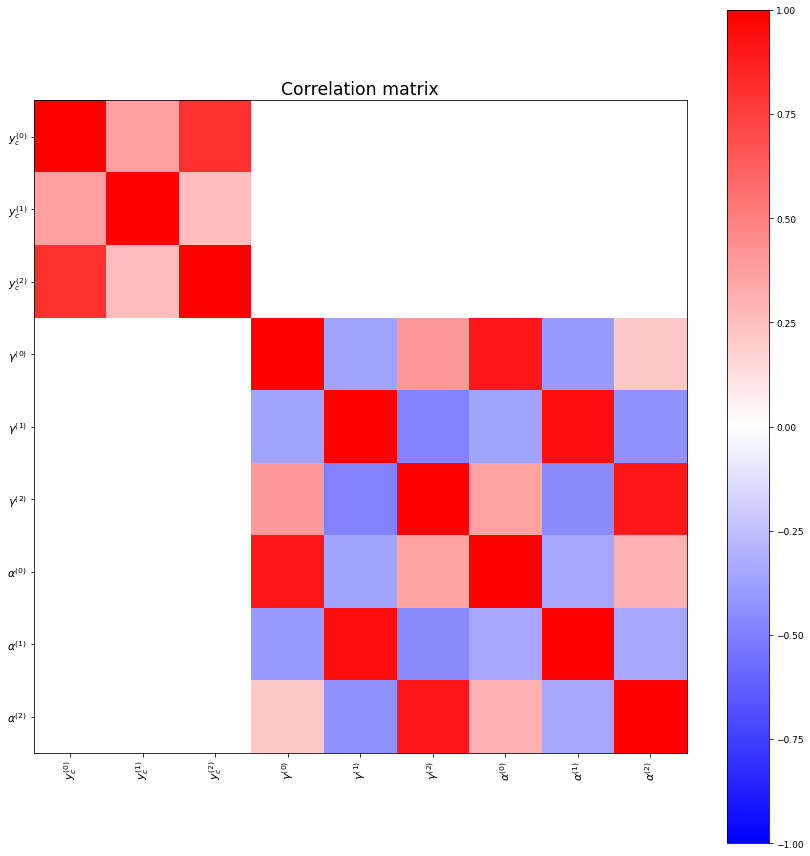

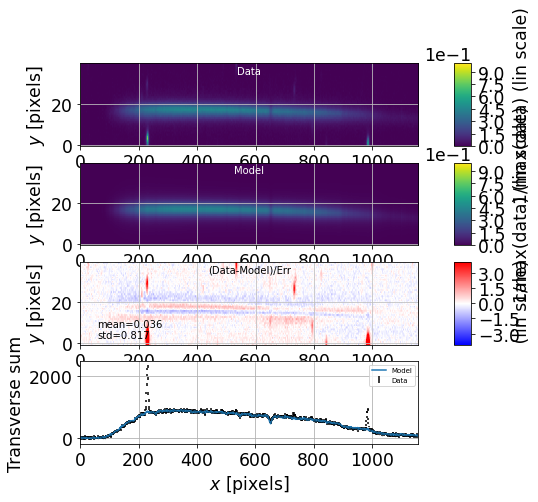

2021-11-02 18:19:35  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude        x_c   ...         Dy         Dy_disp_axis
-------------------- ------ ... ------------------ ------------
 -2.6740956994313985    0.0 ... -4.557619963687145          0.0
 -19.766960737425613    1.0 ... -4.553262422408565          0.0
  -16.43854860658307    2.0 ... -4.548917761580469          0.0
  1.0982842903484864    3.0 ... -4.544585981202843          0.0
  16.118319297017003    4.0 ... -4.540267081275687          0.0
   6.969245579060235    5.0 ... -4.535961061799014          0.0
  21.756579865567918    6.0 ... -4.531667922772812          0.0
  0.6468343308433013    7.0 ... -4.527387664197079          0.0
   5.724351231716903    8.0 ...  -4.52312028607183          0.0
-0.42382950949390774    9.0 ... -4.518865788397051          0.0
                 ...    ... ...                ...          ...
   89.08124952111817 1147.0 ... -8.024

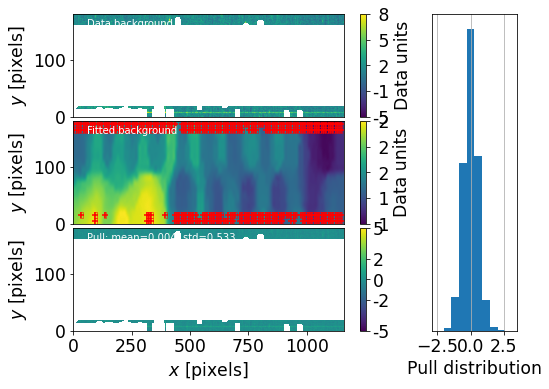

2021-11-02 18:19:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=1.690 ADU/s, RMS=2.013 ADU/s.
2021-11-02 18:19:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [576:1734,1011:1192] (size (1158, 181))
	New target position in spectrogram frame: [-425.43561698738677, 90.6298025558317]


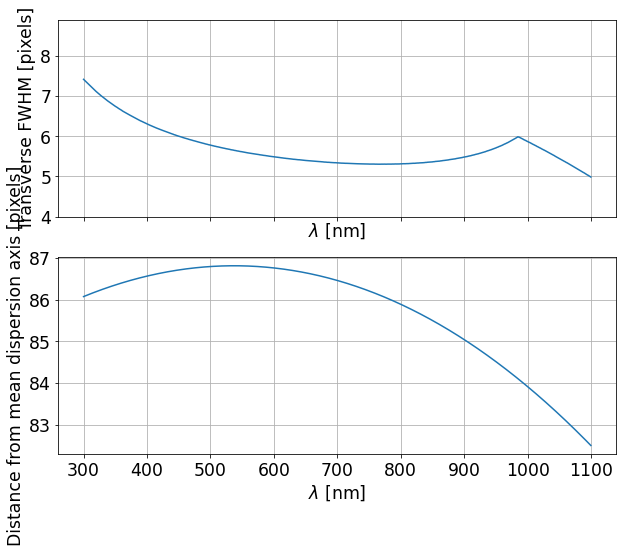

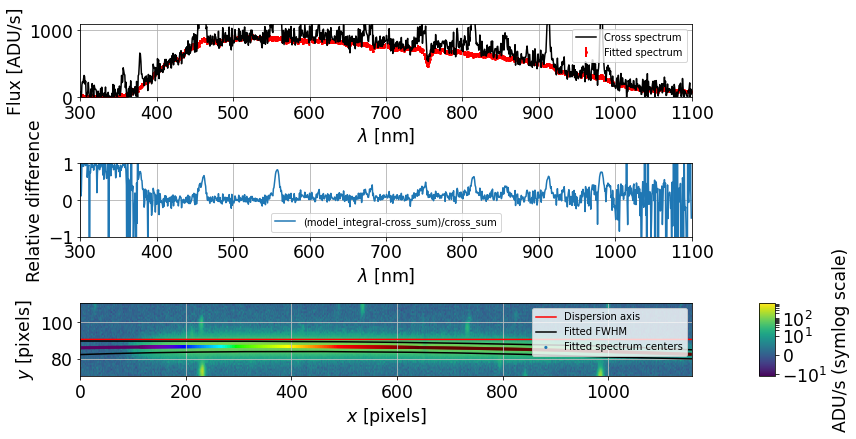

2021-11-02 18:19:39  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


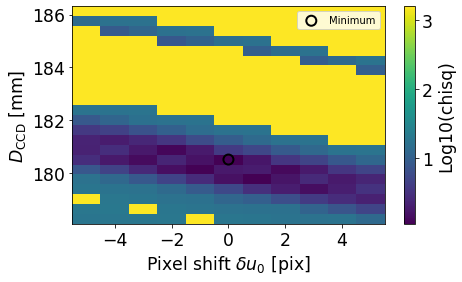

2021-11-02 18:20:02  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.016pix
	D = 179.922 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.8 sigma shift)
2021-11-02 18:20:04  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-11-02 18:20:18  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=4.8143e+05 initial chisq_red=11.783
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-2.61064451  0.00942635]
	New parameters: [-1.904       0.00942635]
	Final cost=2.8377e+05 final chisq_red=6.9454 computed in 11.50s
2021-11-02 18:20:31  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=2.8377e+05 initial chisq_red=6.9454
		 Line search: alpha_min=5.14 iter=1 funcalls=6
	Parameter shifts: [-7.92988571 -0.19615532]
	New parameters: [-1.904      -0.18672898]
	Final cost=77350 final chisq_red=1.8931 computed in 13.15s
2021-11-02 18:20:43 

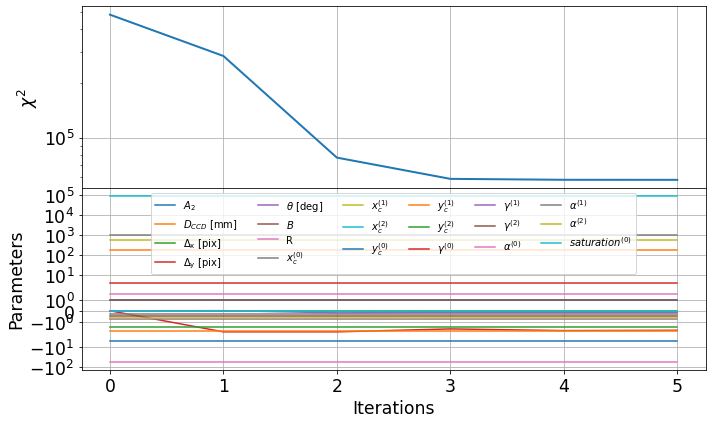

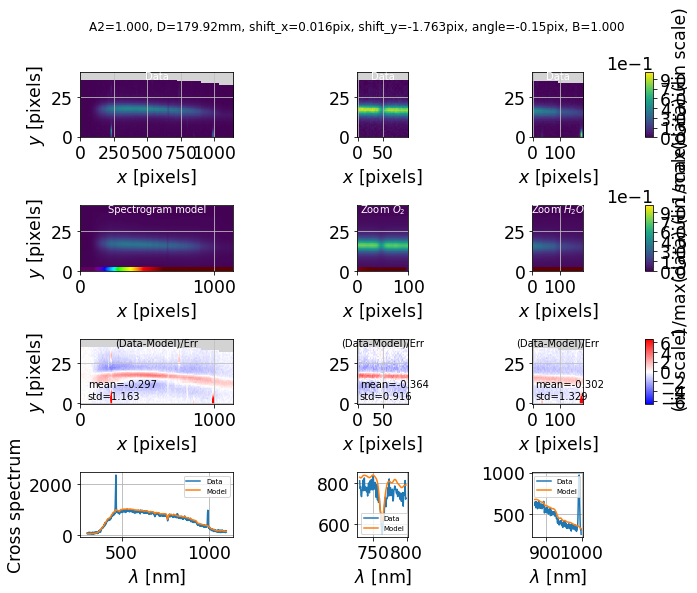

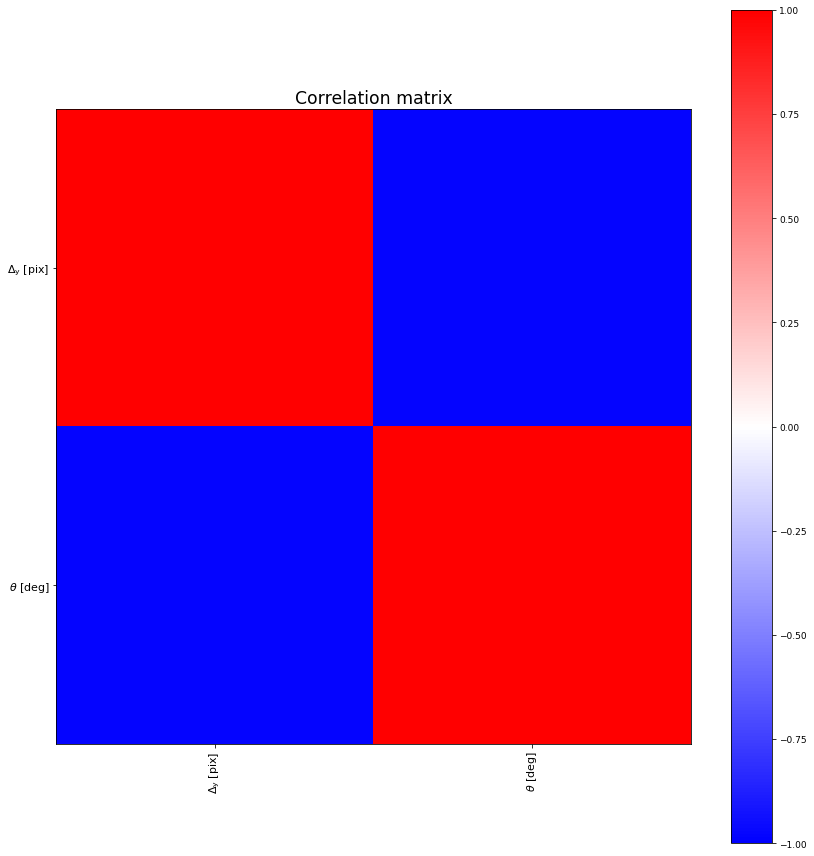

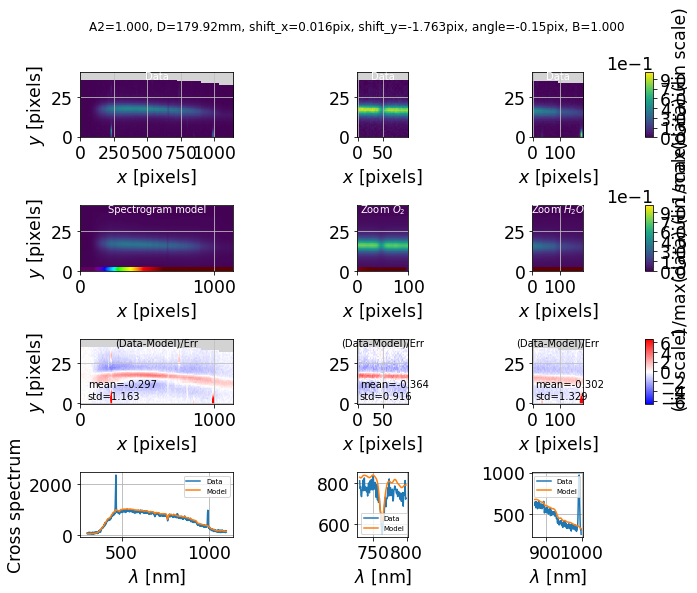

2021-11-02 18:21:15  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.79922197e+02  1.56893913e-02 -1.76343111e+00
 -1.54709797e-01  1.00000000e+00 -5.46065827e+01  1.00493947e+03
  5.78500000e+02  6.44725197e-14 -4.90679036e+00 -1.78603724e+00
 -1.43686685e+00  3.79888166e+00 -6.99979860e-01 -4.38280521e-01
  1.54706991e+00 -3.27432728e-01 -6.94295044e-01  8.50003574e+04]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-11-02 18:21:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=58213 initial chisq_red=1.4248
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 1.08231773e-02 -1.77795633e-04 -1.04470894e+00  6.70418146e-02
 -1.09124458e+00  1.00782539e-01  6.16465779e-02 -2.03183257e-01]
	New parameters: [-1.75260793

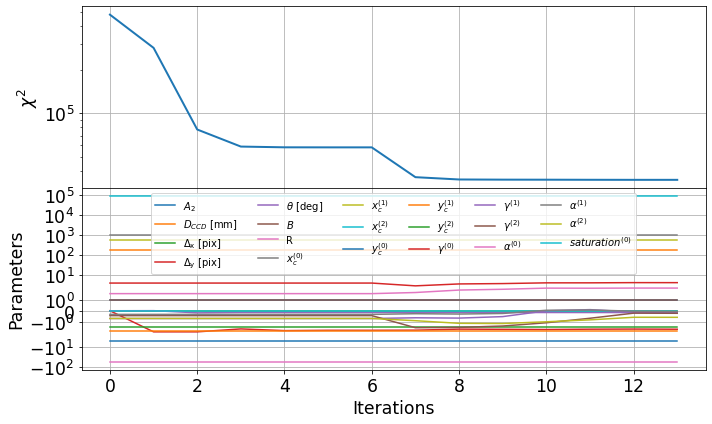

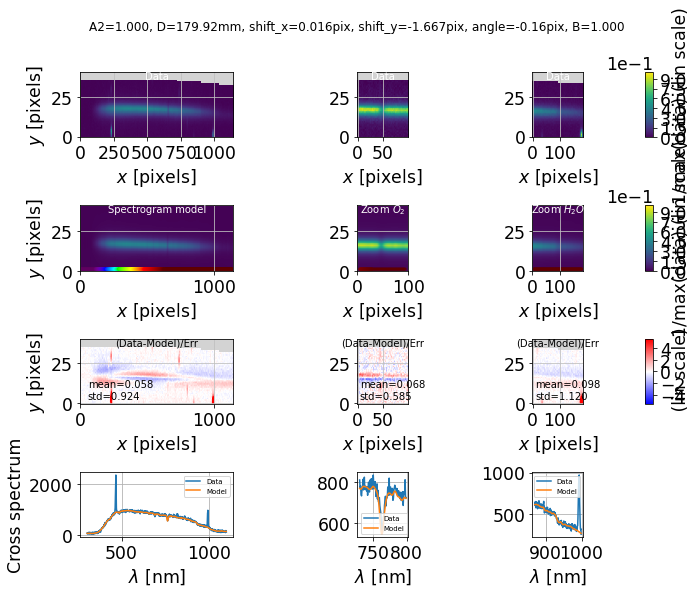

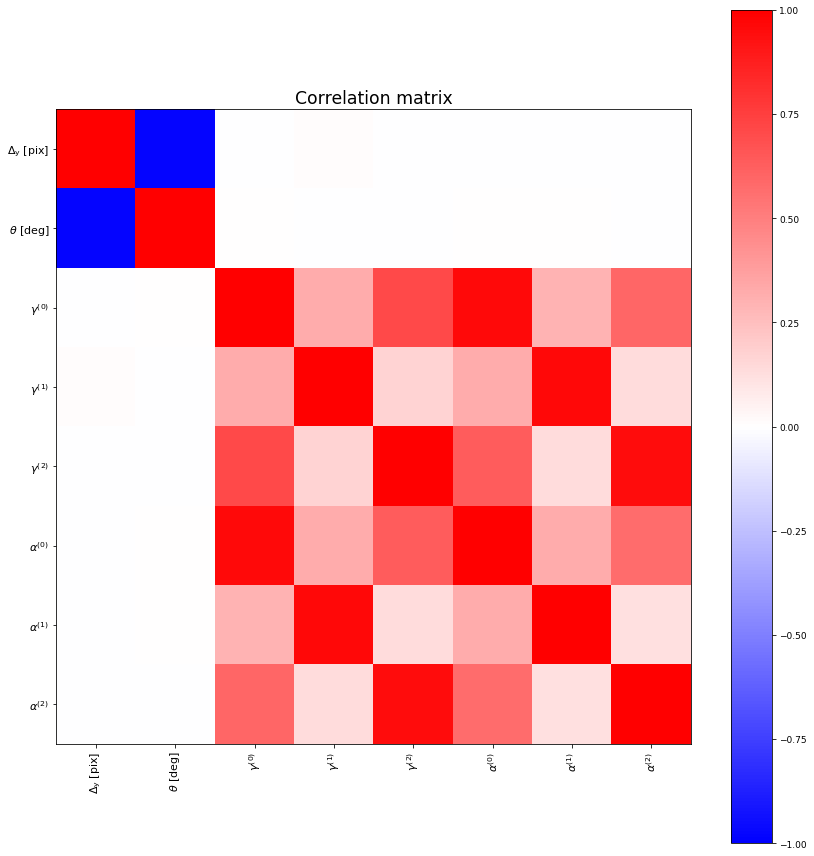

2021-11-02 18:23:44  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
2021-11-02 18:23:59  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[3.953073  ],
       [3.95301392]]), array([2.18255728e-10, 2.18255728e-10]))
           fun: 2.1825572840246782e-10
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 29
        status: 0
       success: True
             x: array([3.953073])
2021-11-02 18:23:59  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 14.234640836715698s


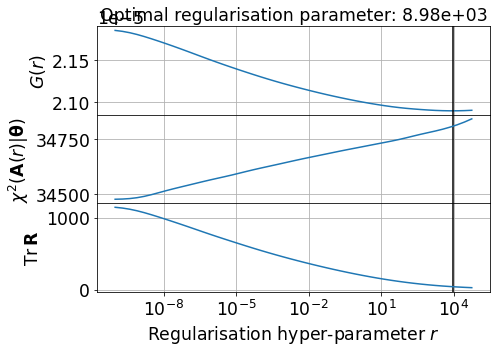

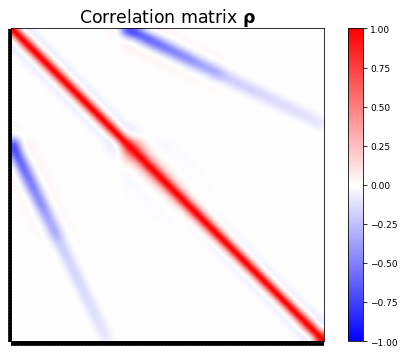

2021-11-02 18:24:23  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 8975.796607669467
	Tr(R) = 39.97396900834907
	N_params = 1158
	N_data = 40858 (without mask and outliers)
2021-11-02 18:24:25  FullForwardModelFitWorkspace run_ffm_minimisation WARNING 
	Trace of final covariance matrix (27148.164033039793) is below the trace of the prior covariance matrix (623933.4304138982). This is probably due to a very high regularisation parameter in case of a bad fit. Therefore the final covariance matrix is mulitiplied by the ratio of the traces and the amplitude parameters are very close the amplitude priors.
2021-11-02 18:24:45  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=34812 initial chisq_red=0.85224
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.60347977e-03  8.95251606e-05  1.62877251e-02  3.51155110e-03
  4.65126553e-02  6.77936270e-03  1.35411498e-03  2.30185337e-02]
	New parameters: [-1.6

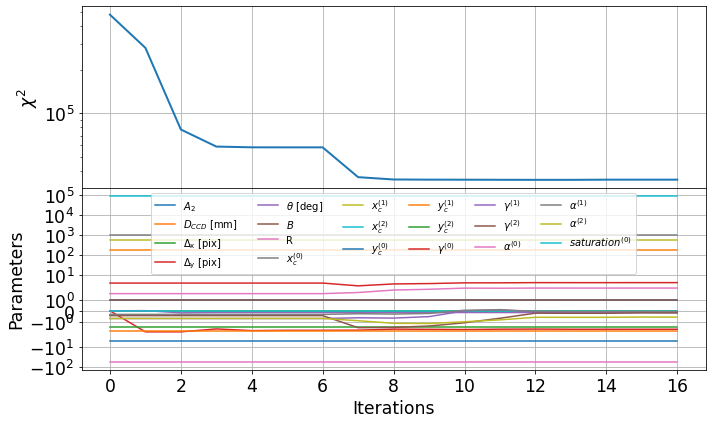

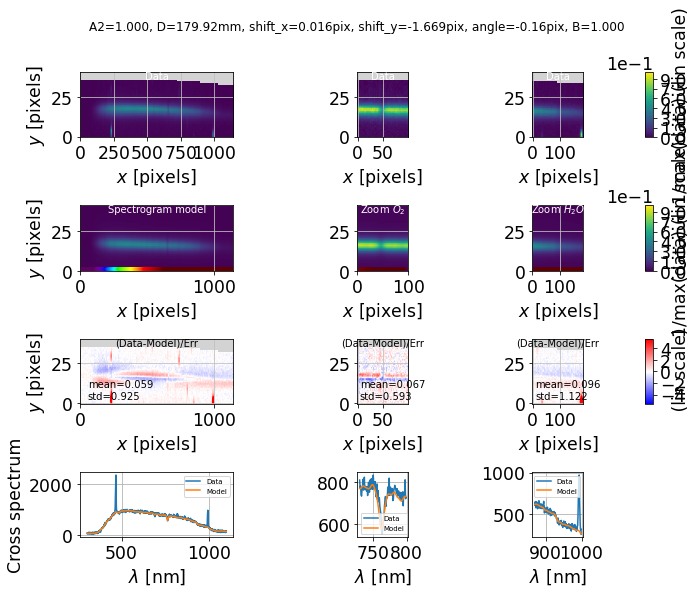

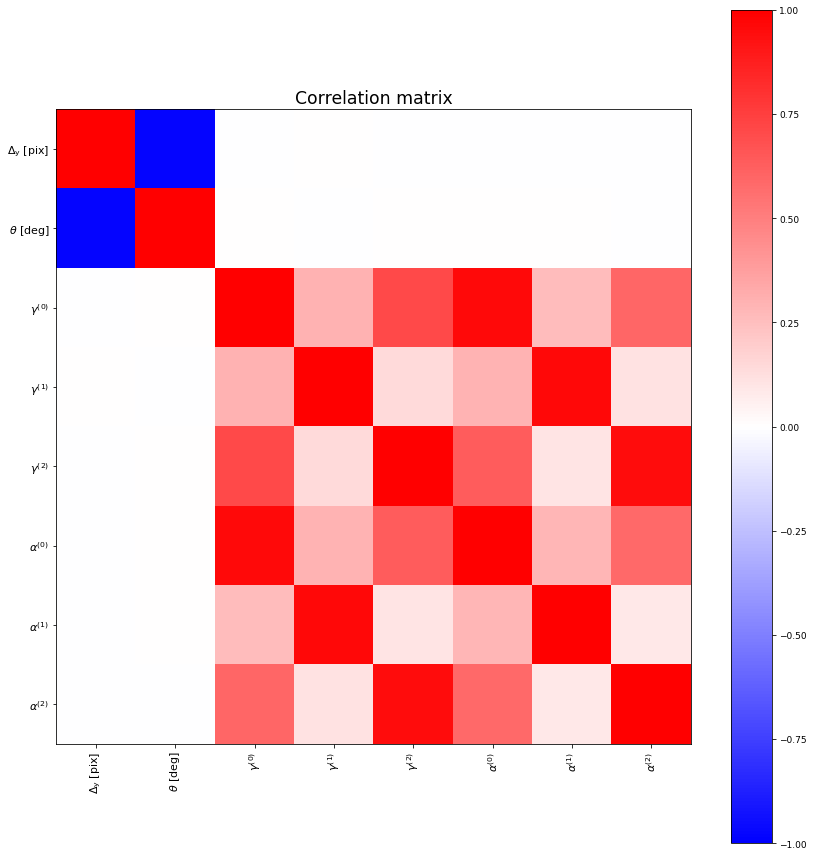

2021-11-02 18:25:07  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [2548, 3705, 3706, 4863, 4864]
2021-11-02 18:25:07  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-11-02 18:25:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=32555 initial chisq_red=0.797
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 3.38738074e-04 -1.87611430e-05  9.77474492e-03 -1.94194268e-02
  1.95908849e-02  5.22886786e-03 -1.07561514e-02  1.01778090e-02]
	New parameters: [-1.66821443 -0.15898738  4.00624074 -0.17796869 -0.17187339  2.13839571
 -0.07539101 -0.56369481]
	Final cost=32555 final chisq_red=0.797 computed in 18.18s
2021-11-02 18:25:44  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=32555 initial chisq_red=0.797
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter sh

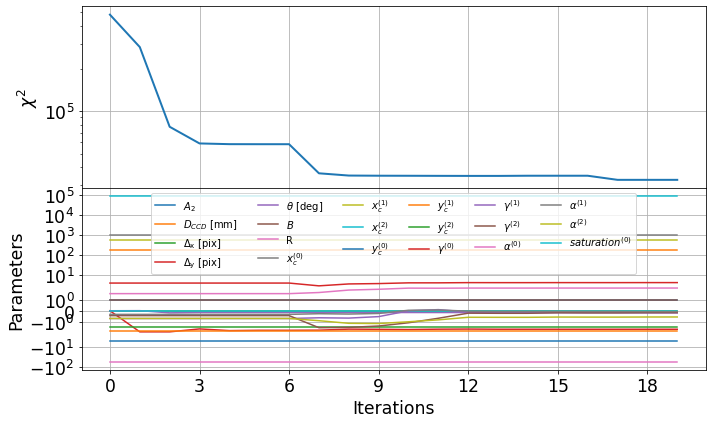

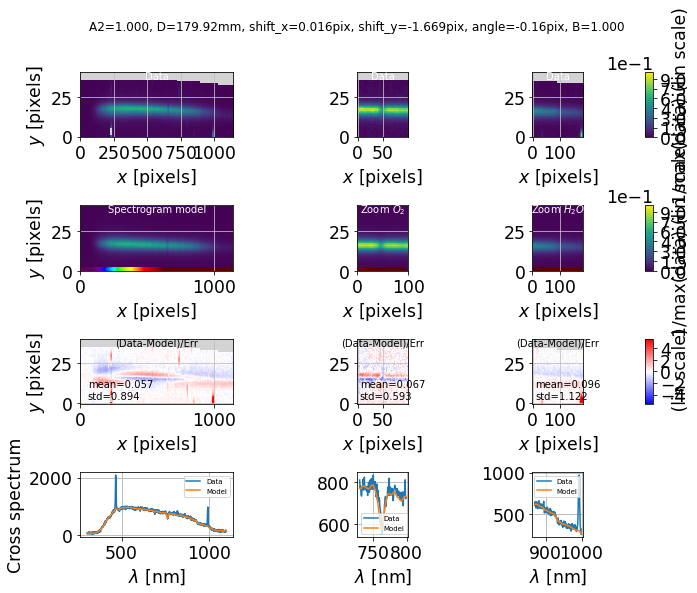

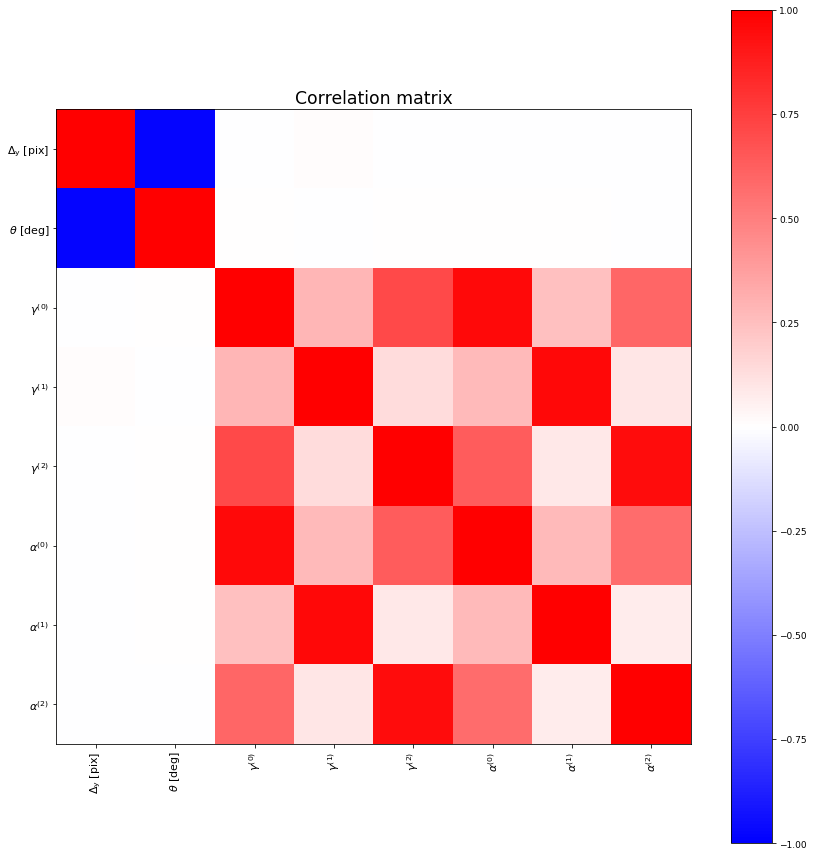

2021-11-02 18:25:49  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [2548, 3705, 3706, 4863, 4864]
2021-11-02 18:25:49  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-11-02 18:25:49  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-11-02 18:25:49  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 274.3768529891968s


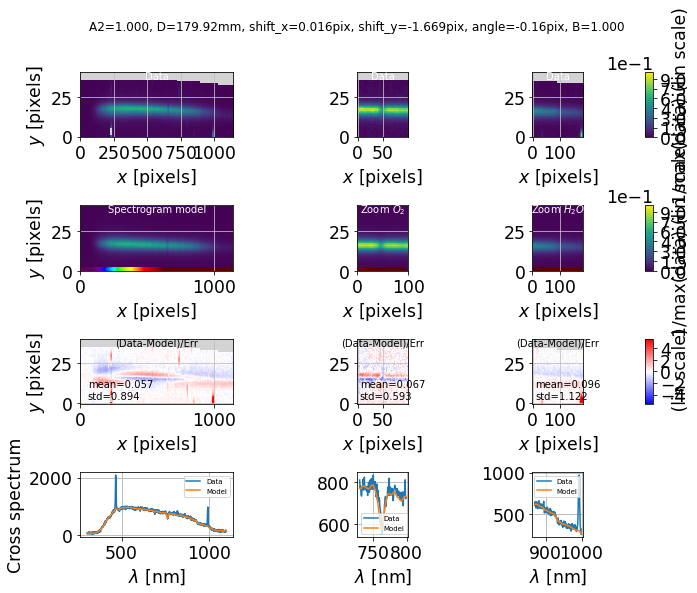

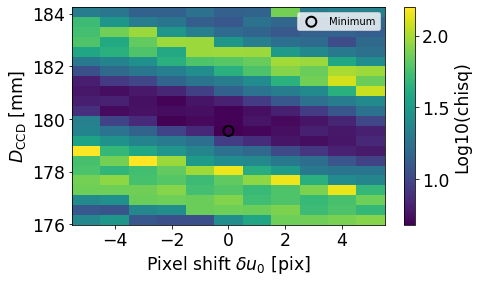

2021-11-02 18:26:14  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 0.305pix
	D = 179.600 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.2 sigma shift)
2021-11-02 18:26:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=32559 initial chisq_red=0.79709
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-8.28151526e-04 -2.09036457e-05 -2.21978115e-03 -3.12760186e-03
 -4.22283682e-03 -1.16320224e-03 -1.85180928e-03 -2.36075020e-03]
	New parameters: [-1.66995878 -0.15895996  4.00507006 -0.18600757 -0.17135219  2.13774158
 -0.07993847 -0.56360288]
	Final cost=32559 final chisq_red=0.79709 computed in 17.39s
2021-11-02 18:26:56  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=32559 initial chisq_red=0.79709
		 Line search: alpha_min=0.124 iter=4 funcalls=8
	Parameter shifts: [-5.70906308e-04  3.01132197e-05  3.47619414e-04  1.92483625e-04
  7.90288661e-04  1.68078218e-04  1.08782429e-04  4.2093376

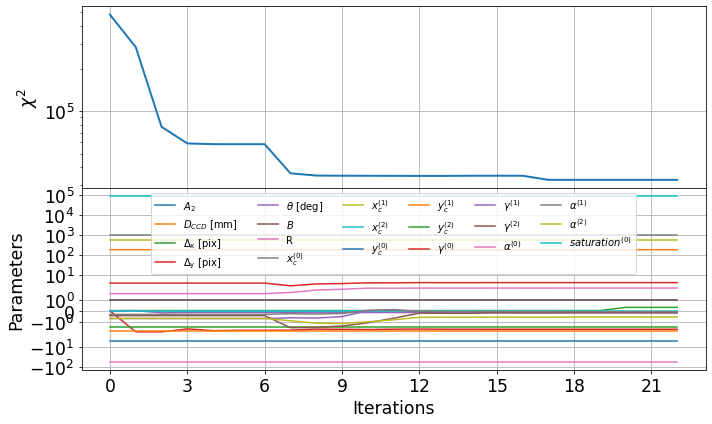

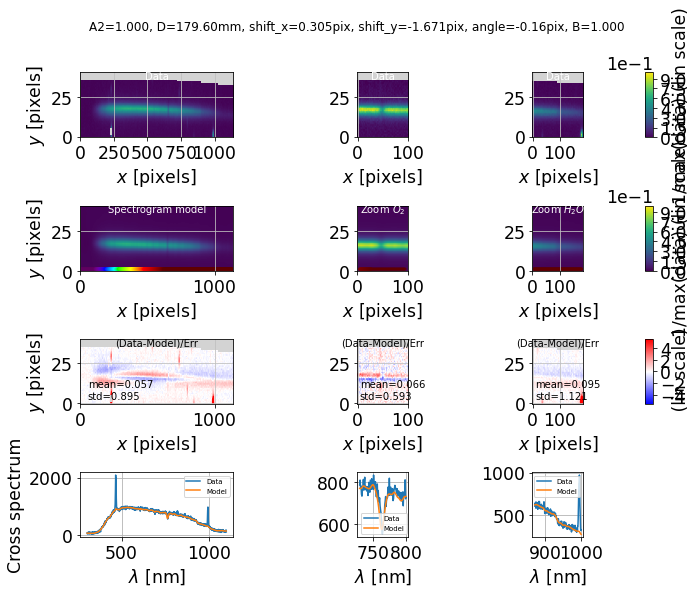

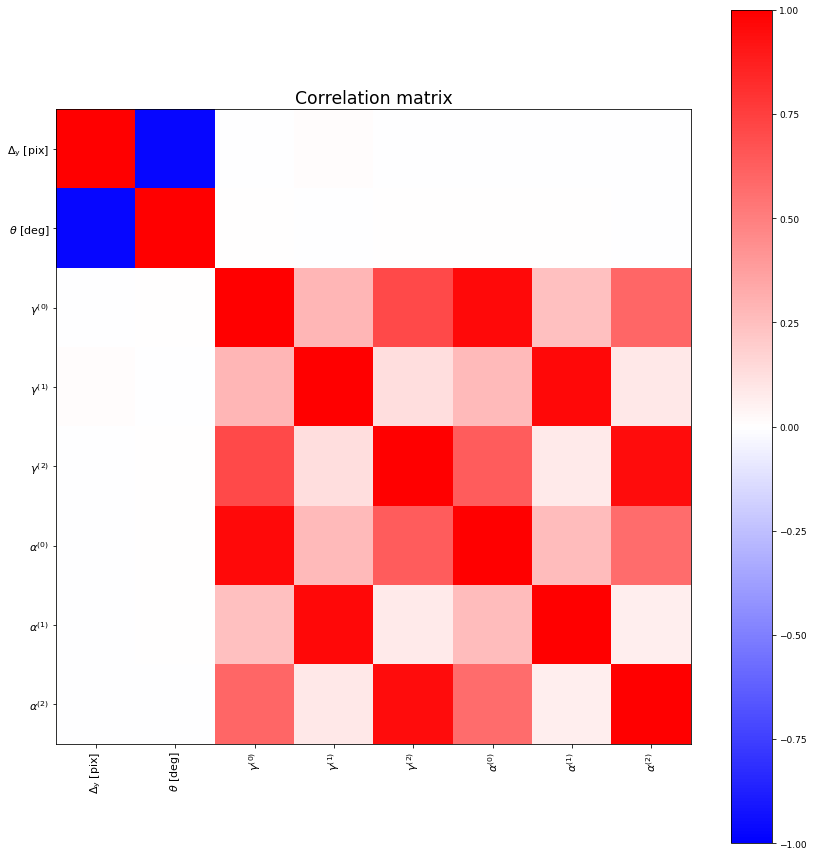

2021-11-02 18:27:01  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [2548, 3705, 3706, 4863, 4864]
2021-11-02 18:27:01  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 5 / 47478 data points (0.01%) at more than 20-sigma from best-fit model.
2021-11-02 18:27:01  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-11-02 18:27:01  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 346.1664090156555s


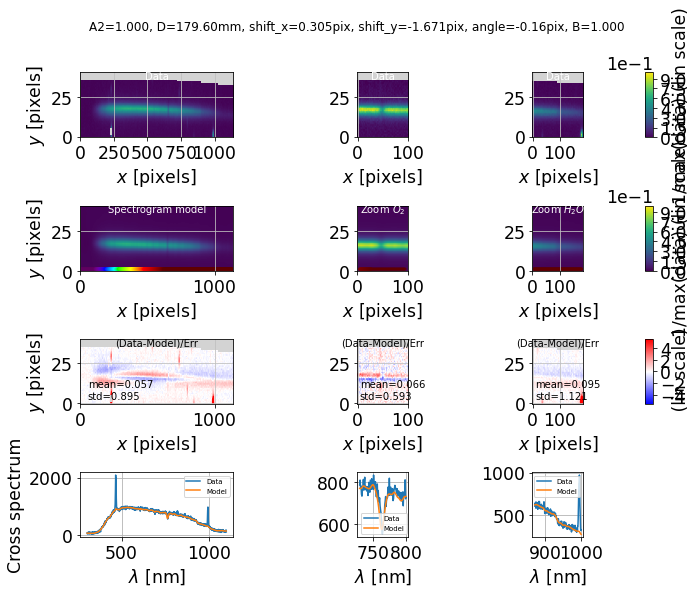

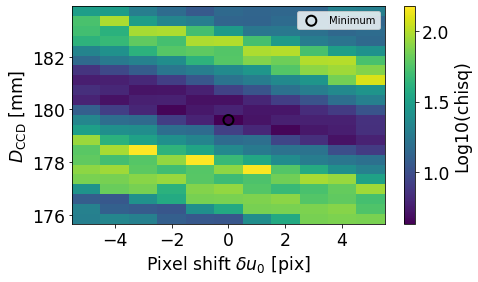

2021-11-02 18:27:22  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.516pix
	D = 179.741 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -3.0 sigma shift)
2021-11-02 18:27:23  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-11-02 18:27:23  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-11-02 18:27:24  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits
2021-11-02 18:27:24  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrogram.fits


    Line    Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced       nm          nm     
----------- --------- --------- ... --------- ----------- ------------
   $Fe_{I}$   382.172 382.38495 ...  7.274832   1.0201622    1.6625434
  $Ca_{II}$ 393.49777  393.9311 ...  7.274832  0.61423683    1.7254286
  $Ca_{II}$ 396.97995 397.01672 ...  7.274832   0.3247498   0.85644484
$H\epsilon$   397.133 402.81036 ...  7.274832 0.080789894  0.075309604
  $H\delta$  410.3374 410.25302 ...  7.274832   0.3781419    0.6797784
   $Fe_{I}$ 430.93433  426.7839 ...  7.274832   1.2569317    3.5450194
  $H\gamma$  434.1454 433.19864 ...  7.274832  0.61815983     2.280876
   $Fe_{I}$ 438.50186 440.62482 ...  7.274832  0.83705616     2.627045
   $He_{I}$  447.2498  448.2219 ...  7.274832  0.15254399   0.44647577
   $H\beta$ 486.46292 486.94565 ... 7.0922627  0.34237862    0.3586213
   $Mg_{I}$  518.5336 517.98846 ... 7.0922627 0.101174705   0.35659027
   $Fe

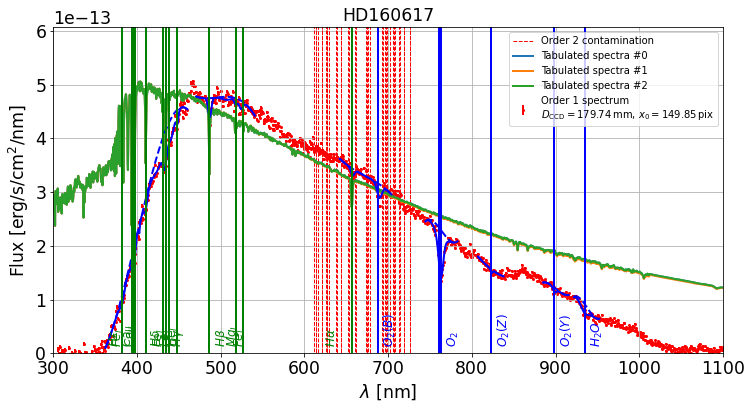

In [71]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [72]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_lines.csv']

In [73]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/